In [1]:
import os, sys, shutil, h5py, json
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import scipy
import numpy as np
import tensorflow as tf
import pickle
import numpy
import matplotlib.pyplot as plt
import glob

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from shutil import copy

from keras.models import Model
from keras.models import model_from_json
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, ZeroPadding2D, Permute, Reshape, Input, Flatten
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

%cd /content/gdrive/My\ Drive/Deep_Learning/Images_Cropped/

with open("Training_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  training_samples = pickle.load(handle)

with open("Test_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  test_samples = pickle.load(handle)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Deep_Learning/Images_Cropped


In [0]:
# Normalization functions
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

import torch.nn.functional as F
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def standarize_pictures(picture_array):
  # Takes in numpy array of picture, and returns a numpy
  tensor_stn_pic = torch.zeros_like(torch.from_numpy(picture_array))
  for i, picture in enumerate(picture_array):
    stn_pic = transform(picture)
    stn_pic = stn_pic.permute(1, 2, 0)
    tensor_stn_pic[i, :, :, :] = stn_pic
    #stn_pic = stn_pic.numpy()
  return tensor_stn_pic.numpy()


def normalization_global_equalization(image):
  #image = img_as_ubyte(image)
  return exposure.equalize_hist(image)

def normalization_local_equalization(image):
  #image = img_as_ubyte(image[:, :, 0]) 
  image = image[:, :, 0]
  selem = disk(30) # The neighborhood expressed as a 2-D array of 1’s and 0’s.
  return rank.equalize(image, selem=selem)/255

def LocalContrastNorm(image,radius=9):
    """
    image: torch.Tensor , .shape => (1,channels,height,width) 
    
    radius: Gaussian filter size (int), odd
    """
    if radius%2 == 0:
        radius += 1
    def get_gaussian_filter(kernel_shape):
        x = np.zeros(kernel_shape, dtype='float64')
 
        def gauss(x, y, sigma=2.0):
            Z = 2 * np.pi * sigma ** 2
            return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
        mid = np.floor(kernel_shape[-1] / 2.)
        for kernel_idx in range(0, kernel_shape[1]):
            for i in range(0, kernel_shape[2]):
                for j in range(0, kernel_shape[3]):
                    x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
        return x / np.sum(x)
    
    n,c,h,w = image.shape[0],image.shape[1],image.shape[2],image.shape[3]

    gaussian_filter = torch.Tensor(get_gaussian_filter((1,c,radius,radius)))
    gaussian_filter = gaussian_filter.double() # My code
    filtered_out = F.conv2d(image,gaussian_filter,padding=radius-1)
    mid = int(np.floor(gaussian_filter.shape[2] / 2.))
    ### Subtractive Normalization
    centered_image = image - filtered_out[:,:,mid:-mid,mid:-mid]
    centered_image = centered_image.double() # My code
    
    ## Variance Calc
    sum_sqr_image = F.conv2d(centered_image.pow(2),gaussian_filter,padding=radius-1)
    s_deviation = sum_sqr_image[:,:,mid:-mid,mid:-mid].sqrt()
    
    #per_img_mean = denom.mean()
    per_img_mean = s_deviation.mean()

    ## Divisive Normalization
    divisor = np.maximum(per_img_mean.numpy(),s_deviation.numpy())
    divisor = np.maximum(divisor, 1e-4)
    new_image = centered_image / torch.Tensor(divisor)
    return new_image

def LCN_from_numpy(image):
  # Input should be 420, 420, 1
  img_torch = torch.from_numpy(image.reshape(1, 420, 420, 1))
  img_torch = img_torch.permute(0, 3, 1, 2)
  img_torch = LocalContrastNorm(img_torch)
  return img_torch.permute(0, 2, 3, 1).numpy()

In [0]:
np.random.seed(45)
np.random.shuffle(training_samples)
np.random.shuffle(test_samples)

training_images = []
training_labels = []
test_images = []
test_labels = []

for picture, label, _, _ in training_samples:
  training_images.append(picture)
  training_labels.append(label)

for picture, label, _, _ in test_samples:
  test_images.append(picture)
  test_labels.append(label)


training_images = standarize_pictures(np.array(training_images))
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

check_image = test_images[0]
test_images = standarize_pictures(test_images)

(34, 420, 420, 1)
(1, 420, 420, 1)


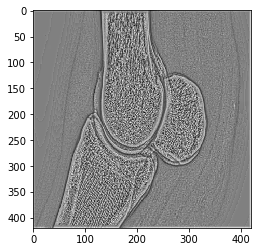

In [5]:
check_image = LCN_from_numpy(check_image)
print(test_images.shape)
print(check_image.shape)
plt.imshow(check_image[0, :, :, 0], cmap=plt.get_cmap('gray'))
#print(check_image)

In [0]:
json_file = open('aNoAugmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
#print(model.summary())













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
PATIENCE = 50
#VAL_SPLIT = 0.25
BATCH_SIZE = 2
EPOCHS = 100

save_name = 'aNoAugmentation_Standardized'
loss_func = 'sparse_categorical_crossentropy'
AO = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

max_train_acc = []
max_val_acc = []

for i in range(10):
  print(i)
  if i == 0:
    model.compile(loss=loss_func, optimizer=AO, metrics=['accuracy'])
    json_string = model.to_json()
    with open(str(save_name) + '.json', 'w') as f:
        f.write(json_string)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=PATIENCE, verbose=1, mode='max')
  checkpoint = ModelCheckpoint(str(save_name) + "_" + str(i) +  '.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint, early_stopping]

  history = model.fit(training_images, training_labels, batch_size=BATCH_SIZE, validation_data=(test_images, test_labels), epochs=EPOCHS, callbacks=callbacks_list)
  '''
  scipy.io.savemat(str(save_name) + "_" + str(i) + '_TrainingLog.mat', {"val_acc": history.history['val_acc'],
                                                            "acc": history.history['acc'],
                                                            "loss": history.history['loss']})
  '''

  print("Max train acc: " + str(np.max(history.history['acc'])))
  print("Max val acc: " + str(np.max(history.history['val_acc'])))
  max_train_acc.append(np.max(history.history['acc']))
  max_val_acc.append(np.max(history.history['val_acc']))

  model = model_from_json(loaded_model_json) # Restarts weights
  model.compile(loss=loss_func, optimizer=AO, metrics=['accuracy'])
  

0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 130 samples, validate on 34 samples
Epoch 1/100
130/130 [==============================] - 9s 73ms/step - loss: 1.1103 - acc: 0.5077 - val_loss: 0.7641 - val_acc: 0.4706

Epoch 00001: val_acc improved from -inf to 0.47059, saving model to aNoAugmentation_Standardized_0.hdf5
Epoch 2/100
130/130 [==============================] - 1s 11ms/step - loss: 0.8715 - acc: 0.5769 - val_loss: 0.6800 - val_acc: 0.5294

Epoch 00002: val_acc improved from 0.47059 to 0.52941, saving model to aNoAugmentation_Standardized_0.hdf5
Epoch 3/100
130/130 [==============================] - 1s 11ms/step - loss: 0.9698 - acc: 0.5231 - val_loss: 0.7010 - val_acc: 0.5882

Epoch 00003: val_acc improved from 0.52941 to 0.58824, saving model to aNoAugmentation_Standardized_0.hdf5
Epoch 4/100
130/130 [==============================] - 1s 11ms/step - loss: 0.8025 - acc: 0.5769 - val_loss: 0.5962 - val_acc: 0.705

In [0]:
print(max_train_acc)
print(max_val_acc)

from statistics import stdev
print(np.mean(max_train_acc))
print(stdev(max_train_acc))

print(np.mean(max_val_acc))
print(stdev(max_train_acc))



[1.0, 0.9846153846153847, 0.9846153846153847, 1.0, 1.0, 0.5076923076923077, 1.0, 1.0, 1.0, 1.0]
[0.7352941176470589, 0.7058823529411765, 0.7647058823529411, 0.7941176470588235, 0.7352941176470589, 0.5, 0.6470588235294118, 0.7352941176470589, 0.6764705882352942, 0.7058823529411765]
0.9476923076923077
0.1547324895642758
0.7
0.1547324895642758
